In [16]:
%%HTML
<style type='text/css'>
    *{
        # background-color:#E3EDCD;
        # background-color:black;
        # color:white;
        
    }
    h1{
        color:#1976d2;
    }
    h2{
        color:#f57c00;
    }
    h3{
        color:#ba37ff;
    }
    h4{
        color:green;
    }
    table{
        border:1px solid black !important;
        border-collapse:collapse !important;
    }
    th{
        background-color:blueviolet !important;
        text-align:center;
        color:white;
    }
    th,td{
        border:0.1px solid black !important;
        transition:0.2s all liner;
        
    }
    td:hover{
        transform:scale(1.1);
        background-color:orange;
        color:blueviolet;
    }
    .raw{
        white-space:pre;
    }
    .atcenter{
        text-align:center !important;
    }
    .imp{
        color:red;
        font-weight:bolder;
    }
    table.tts tr:first-child td:nth-child(2){
        background-color:red !important;
    }
    table.tts tr:nth-child(2) td:last-child{
        background-color:red !important;
    }
</style>
        

## 5.3 超参数与模型验证


在上一节中，我们介绍了有监督机器学习模型的基本步骤：        
(1) 选择模型类；            
(2) 选择模型超参数；  
(3) 用模型拟合训练数据；   
(4) 用模型预测新数据的标签。  
前两步——模型选择和超参数选择——可能是有效使用各种机器学习工 
具和技术的最重要阶段。为了作出正确的选择，我们需要一种方式来验    
证选中的模型和超参数是否可以很好地拟合数据。这看起来是很简单，      
但要顺利地完成必须避过很多坑。    

### 5.3.1 什么是模型验证

模型验证（model validation）其实很简单，就是在选择模型和超参数之
后，通过对训练数据进行学习，对比模型对已知数据的预测值与实际值
的差异。        
在下面的几节中，我们首先通过一个简单方法实现模型验证，告诉你为
什么那样做行不通。之后，介绍如何用留出集（holdout set）与交叉检
验（cross-validation）实现更可靠的模型验证。       

01. 错误的模型验证方法           
让我们再用前面介绍过的鸢尾花数据来演示一个简单的模型验证方
法。首先加载数据：

In [1]:
from sklearn.datasets import load_iris
iris = load_iris()
X = iris.data
y = iris.target

然后选择模型和超参数。这里使用一个 k 近邻分类器，超参数为
n_neighbors=1。这是一个非常简单直观的模型，“新数据的标签
与其最接近的训练数据的标签相同”：


In [3]:
from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)

然后训练模型，并用它来预测已知标签的数据：

In [4]:
model.fit(X,y)
y_model = model.predict(X)

最后，计算模型的准确率：

In [5]:
from sklearn.metrics import accuracy_score
accuracy_score(y, y_model)

1.0

准确得分是 1.0，也就是说模型识别标签的正确率是 100% ！但是
这样测量的准确率可靠吗？我们真的有一个在任何时候准确率都是
100% 的模型吗？                              
你可能已经猜到了，答案是否定的。其实这个方法有个根本缺陷：
它用同一套数据训练和评估模型。另外，最近邻模型是一种与距
离相关的评估器，只会简单地存储训练数据，然后把新数据与存储
的已知数据进行对比来预测标签。在理想情况下，模型的准确率总
是 100%。


02. 模型验证正确方法：留出集

那怎么才能模型验证呢？其实留出集可以更好地评估模型性能，也
就是说，先从训练模型的数据中留出一部分，然后用这部分留出来
的数据来检验模型性能。在 Scikit-Learn 里面用
train_test_split 工具就可以实现：

In [8]:
from sklearn.model_selection import train_test_split  
#引入sklearn.model_selection中的训练集测试集划分

# from sklearn.cross_validation import train_test_split --旧的语法过时报错
# 每个数据集分一半数据
X1, X2, y1, y2 = train_test_split(X, y, random_state=0,
train_size=0.5)
# 用模型拟合训练数据
model.fit(X1, y1)
# 在测试集中评估模型准确率
y2_model = model.predict(X2)
accuracy_score(y2, y2_model)

0.9066666666666666

<table class='tts'>
    <tr>
        <td>第一轮</td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
        <td>验证集</td>
    </tr>
    <tr>
        <td>第二轮</td>
        <td>验证集</td>
        <td>&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;</td>
    </tr>
</table>

<p class='atcenter'>5-22两轮交叉验证</p>

这里进行了两轮验证实验，轮流用一半数据作为留出集。如果还有
前面的数据集，我们可以这样实现交叉检验：

In [17]:
y2_model = model.fit(X1, y1).predict(X2) 
#第一次将X1作为训练集,y1作为目标向量,用训练好的模型去与猜测X2得到预测的目标向量y2_model
y1_model = model.fit(X2, y2).predict(X1)
# 第二次将X2作为训练集,y2作为目标向量,用训练好的模型去与猜测X1得到预测的目标向量y1_model
accuracy_score(y1, y1_model), accuracy_score(y2, y2_model)

(0.96, 0.9066666666666666)

这样就可以获得两个准确率，将二者结合（例如求均值）获取一个
更准确的模型总体性能。这种形式的交叉检验被称为两轮交叉检验
——将数据集分成两个子集，依次将每个子集作为验证集。
可以通过扩展这个概念，在数据中实现更多轮的实验，例如图 5-23
是一个五轮交叉检验。

<img src='../img/05.png'></img>

<p class='atcenter'>图 5-23：五轮交叉检验</p>

把数据分成五组，每一轮依次用模型拟合其中的四组数据，再预测
第五组数据，评估模型准确率。手动实现这些过程会很无聊，用
Scikit-Learn 的 cross_val_score 函数可以非常简便地实现

In [19]:
from sklearn.model_selection import cross_val_score

In [20]:
cross_val_score(model,X,y,cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

对数据的不同子集重复进行交叉检验，可以让我们对算法的性能有
更好的认识。

In [29]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut())
# 解释:将数据分成了五组采用我们指定的model,X为特征矩阵,y为目标向量
# cv为交叉验证

Scikit-Learn 为不同应用场景提供了各种交叉检验方法，都以迭代
器（iterator）形式在 cross_validation 模块 中实现。例如，我
们可能会遇到交叉检验的轮数与样本数相同的极端情况，也就是说
我们每次只有一个样本做测试，其他样本全用于训练。这种交叉检
验类型被称为 LOO（leave-one-out，只留一个）交叉检验，具体用
法如下：

In [30]:
scores

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

由于我们有 150 个样本，留一法交叉检验会生成 150 轮试验，每次
试验的预测结果要么成功（得分 1.0），要么失败（得分 0.0）。计
算所有试验准确率的均值就可以得到模型的预测准确性了：

In [31]:
scores.mean()

np.float64(0.96)

其他交叉检验机制的用法大同小异。想了解更多关于 Scikit-Learn
交叉检验的内容，可以用 IPython 探索
sklearn.cross_validation 子模块，也可以浏览 Scikit-Learn 的
交叉检验文档（http://scikitlearn.org/stable/modules/cross_validation.html）。

从 Scikit-Learn 0.18 版起，开始用 model_selection 模块代替 cross_validation 模块，并
计划在 0.20 版移除程序包，部分交叉检验类的用法也可能会发生变化。本书按照作者原文保
留 cross_validation，建议读者使用作者建议的 Scikit-Learn 版本运行本书代码。——译者
注


### 5.3.2 选择最优模型

现在已经介绍了验证与交叉检验的基础知识，让我们更进一步，看看如
何选择模型和超参数。这是机器学习实践中最重要的部分，但是许多机
器学习入门教程都一笔带过了这些内容。


关键问题是：假如模型效果不好，应该如何改善？答案可能有以下几
种。                         
- 用更复杂 / 更灵活的模型。    
- 用更简单 / 更确定的模型。  
- 采集更多的训练样本。         
- 为每个样本采集更多的特征。      
问题的答案往往与直觉相悖。换一种更复杂的模型有时可能产生更差的
结果，增加更多的训练样本也未必能改善性能！改善模型能力的高低，
是区分机器学习实践者成功与否的标志。


01. 偏差与方差的均衡

“最优模型”的问题基本可以看成是找出偏差与方差平衡点的问题。
图 5-24 显示的是对同一数据集拟合的两种回归模型。

<img src='../img/06.png'></img>

<p class='atcenter'>图 5-24：高偏差与高方差回归模型</p>

显然，这两个模型拟合得都不是很好，但它们的问题却是不一样
的。              
左边的模型希望从数据中找到一条直线。但由于数据本质上比直线
要复杂，直线永远不可能很好地描述这份数据。这样的模型被认为
是对数据欠拟合；也就是说，模型没有足够的灵活性来适应数据的
所有特征。另一种说法就是模型具有高偏差。           
右边的模型希望用高阶多项式拟合数据。虽然这个模型有足够的灵
活性可以近乎完美地适应数据的所有特征，但与其说它是十分准确
地描述了训练数据，不如说它是过多地学习了数据的噪音，而不是
数据的本质属性。这样的模型被认为是对数据过拟合，也就是模型
过于灵活，在适应数据所有特征的同时，也适应了随机误差。另一
种说法就是模型具有高方差。               
现在再换个角度，如果用两个模型分别预测 y 轴的数据，看看是什
么效果。在图 5-25 中，浅红色的点是被预测数据集遗漏的点。


<img src='../img/07.png'></img>

<p class='atcenter'>图 5-25：高偏差与高方差模型的训练得分与验证得分</p>

这个分数是 R<sup>2</sup>，也称为判定系数
（https://en.wikipedia.org/wiki/Coefficient_of_determination)  
用来
衡量模型与目标值均值的对比结果。R<sup>2</sup> = 1 表示模型与数据完全吻
合，R<sup>2</sup> = 0 表示模型不比简单取均值好,R<sup>2</sup> 为负表示模型性能很
差。从这两个模型的得分可以得出两条一般性的结论。         
- 对于高偏差模型，模型在验证集的表现与在训练集的表现类
似。       
- 对于高方差模型，模型在验证集的表现远远不如在训练集的表
现。       
如果我们有能力不断调整模型的复杂度，那么我们可能希望训练
得分和验证得分如图 5-26 所示。

图 5-26 通常被称为验证曲线，具有以下特征。

- 训练得分肯定高于验证得分。一般情况下，模型拟合自己接触
过的数据，比拟合没接触过的数据效果要好。     
- 使用复杂度较低的模型（高偏差）时，训练数据往往欠拟合，
说明模型对训练数据和新数据都缺乏预测能力。     
- 而使用复杂度较高的模型（高方差）时，训练数据往往过拟
合，说明模型对训练数据预测能力很强，但是对新数据的预测
能力很差。     
- 当使用复杂度适中的模型时，验证曲线得分最高。说明在该模
型复杂度条件下，偏差与方差达到均衡状态。     

<img src='../img/08.png'></img>

<p class='atcenter'>图 5-26：模型复杂度、训练得分与验证得分的方法关系图</p>

不同模型复杂度的调整方法大不相同。后文在深入介绍各种模型
时，就会讲解每种模型的调整方法。

02. Scikit-Learn验证曲线


下面来看一个例子，用交叉检验计算一个模型的验证曲线。这里用
多项式回归模型，它是线性回归模型的一般形式，其多项式的次数
是一个可调参数。例如，多项式次数为 1 其实就是将数据拟合成一
条直线。若模型有参数 a 和 b，则模型为：  
$$
y=ax+b
$$
多项式次数为 3，则是将数据拟合成一条三次曲线。若模型有参数
a、b、c、d，则模型为：
$$
y=ax^3+bx^2+cx+d
$$
推而广之，就可以得到任意次数的多项式。在 Scikit-Learn 中，可
以用一个带多项式预处理器的简单线性回归模型实现。我们将用一
个管道命令来组合这两种操作（多项式特征与管道命令将在 5.4 节
介绍）：


In [2]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline

In [3]:
def PolynomialRegression(degree=2,**kwargs):
    return make_pipeline(
        PolynomialFeatures(degree),
        LinearRegression(**kwargs)
    )

现在来创造一些数据给模型拟合

<a href='#'>make_data</a>

In [4]:
import numpy as np
def make_data(N,err=1.0,rseed=1):
    # 随机样本数据
    rng = np.random.RandomState(rseed)
    X = rng.rand(N,1)**2
    y = 10 - 1. / (X.ravel() + 0.1)
    if err > 0:
        y += err * rng.randn(N)
    return X, y
X, y = make_data(40)

In [8]:
X.shape

(40, 1)

In [9]:
y.shape

(40,)

通过数据可视化，将不同次数的多项式拟合曲线画出来（如图 5-27
所示）：

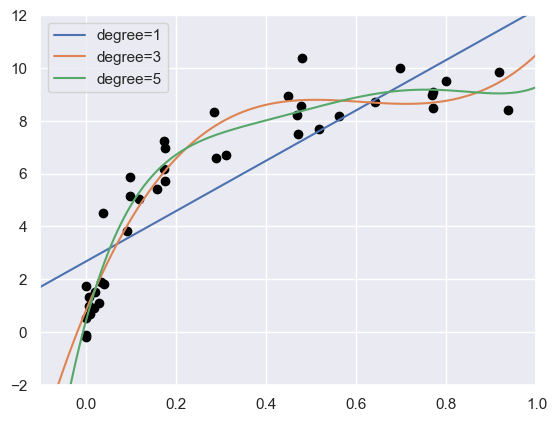

In [5]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # 设置图形样式
X_test = np.linspace(-0.1, 1.1, 500)[:, None]
plt.scatter(X.ravel(), y, color='black') 
#%%!注意,.reval()是把二位的特征矩阵转换为一维数组,这样我们画散点图才能画出来
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best');


<p class='atcenter'>图 5-27：用三种多项式回归模型拟合一份数据</p>

这个例子中控制模型复杂度的关键是多项式的次数，它只要是非负
整数就可以。那么问题来了：究竟多项式的次数是多少，才能在偏
差（欠拟合）与方差（过拟合）间达到平衡？

我们可以通过可视化验证曲线来回答这个问题——利用 ScikitLearn 的 validation_curve 函数就可以非常简单地实现。只要提
供模型、数据、参数名称和验证范围信息，函数就会自动计算验证
范围内的训练得分和验证得分（如图 5-28 所示）：

In [10]:
from sklearn.model_selection import validation_curve

In [19]:
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree',
                                          degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score');


TypeError: too many positional arguments

<p class='imp'>这个错误发生在调用 validation_curve 函数时。问题的根源在于参数的传递方式。具体地，validation_curve 需要一个字符串表示参数名称，例如 'polynomialfeatures__degree'，但代码中的 PolynomialRegression() 返回的是一个包含两个步骤（多项式特征转换和线性回归）的流水线。</p>

解决方法
在 validation_curve 中，参数 'polynomialfeatures__degree' 是用来指定 PolynomialFeatures 的 degree 参数的，因此需要确保传递给 PolynomialRegression() 的模型能够正确识别这个参数。我们可以将 PolynomialRegression 中的 degree 显式地指定为流水线中的一部分。

另外，validation_curve 需要正确的参数命名和传递方式，确保你不会把多余的参数传递给它。

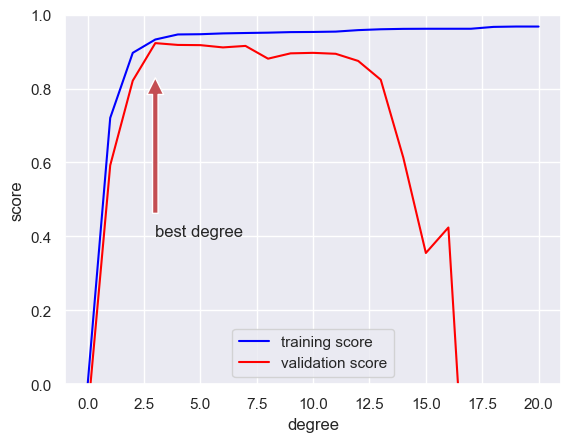

In [35]:
degree = np.arange(0, 21)
# 使用validation_curve来指定好使用的模型为多项式回归PolynomialRegression()
# 其次指定好特征矩阵和目标向量X,y
# 然后指定参数名选取的的参数是多项式回归的项数
# 指定多项式的项数范围为上面选定的0-20
# 其次指明使用7折交叉检验
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          param_name='polynomialfeatures__degree',
                                          param_range=degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0, 1)
plt.annotate('best degree',xy=(3,0.85),xytext=(3,0.4),arrowprops=dict(facecolor='r',shrink=0.05))
plt.xlabel('degree')
plt.ylabel('score');



<p class='atcenter'>图 5-28：图 5-27 的验证曲线（参考图 5-26）</p>

这幅图可以准确显示我们想要的信息：训练得分总是比验证得分
高；训练得分随着模型复杂度的提升而单调递增；验证得分增长到
最高点后由于过拟合而开始骤降。
从验证曲线中可以看出，偏差与方差均衡性最好的是三次多项式。

ax.annotate('cosx',xy=(2,-0.5),xytext=(2,-1.5),arrowprops=dict(facecolor='blue',arrowstyle='->',connectionstyle="angle3,angleA=0,angleB=-90"))
这段代码使用 ax.annotate 在图中添加注释。下面是各个参数的解释：

ax.annotate('cosx', ...)
'cosx' 是注释文本，表示你希望在图中显示的内容。
xy=(2,-0.5)
xy 参数指定了注释文本的目标位置，即箭头指向的坐标 (x=2, y=-0.5)。
xytext=(2,-1.5)
xytext 参数指定了注释文本的起始位置，即文本显示的坐标。这里设置为 (x=2, y=-1.5)，说明文本将位于目标位置下方。
arrowprops=dict(facecolor='blue', arrowstyle='->', connectionstyle="angle3,angleA=0,angleB=-90")
arrowprops 是一个字典，用来控制箭头的样式。
facecolor='blue'：箭头的颜色是蓝色。
arrowstyle='->'：箭头的样式是简单的箭头，指向目标位置。
connectionstyle="angle3,angleA=0,angleB=-90"：定义箭头连接的样式。
angle3 是指使用三个角度来绘制连接线，通常用于展示有弯曲的箭头。
angleA=0 和 angleB=-90 定义了连接箭头的两个角度，表示箭头从起始点以 0 度角度出发，弯曲到 -90 度，最终指向目标位置。

In [24]:
train_score

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        ],
       [0.72060505, 0.73235327, 0.71615237, 0.75517775, 0.6979951 ,
        0.74351307, 0.71104367],
       [0.8966661 , 0.89427274, 0.88460403, 0.90482859, 0.87685741,
        0.90106431, 0.90420325],
       [0.92830604, 0.93586649, 0.93273606, 0.95501615, 0.91919623,
        0.92673491, 0.9402878 ],
       [0.9386132 , 0.94947024, 0.94775706, 0.9632512 , 0.93425141,
        0.94148127, 0.94641559],
       [0.94121068, 0.94988755, 0.94891078, 0.9637873 , 0.93481636,
        0.94464031, 0.94706837],
       [0.94280027, 0.95011515, 0.95028793, 0.96555698, 0.93622172,
        0.94504929, 0.94928043],
       [0.94465044, 0.95166164, 0.95034312, 0.96584535, 0.93731514,
        0.94571392, 0.95274503],
       [0.94465097, 0.95169173, 0.95126473, 0.96709791, 0.93735454,
        0.9484231 , 0.95274521],
       [0.94935834, 0.9537075 , 0.95317786, 0.96799601, 0.93964532,
        0.9490145 , 0.9

<img src='../img/09.png'></img>

解读,为什么我们要使用np.median(train_score, 1) 中的1      
看上图,没截图完整，但总共是21行，7列，21行代表的是我们选取的特征多项式的项数       
每一列代表的是7折交叉检验中每次的得分    
那么我们要比较的是各个项数的得分情况，自然要取得每一行数据的中位数，     
指定np.median(train_score, 1)即为按行来求中位数,axis=1就是按行,如果指为0那么就是按列

In [22]:
train_score.shape

(21, 7)

In [23]:
val_score.shape

(21, 7)

这段代码使用了 validation_curve 函数来评估多项式回归模型在不同多项式度数下的表现。我们逐行分析代码，并解释 np.median(train_score, 1) 中 1 的含义。

代码解读
degree = np.arange(0, 21)

这里创建了一个数组 degree，其元素是从 0 到 20 的整数（21 不包括在内）。这个数组用于定义多项式回归中多项式的度数范围，模型会在这些度数下进行训练和验证。
train_score, val_score = validation_curve(PolynomialRegression(), X, y, param_name='polynomialfeatures__degree', param_range=degree, cv=7)

validation_curve 是一个交叉验证工具，用于评估模型在不同超参数设置下的表现。
PolynomialRegression() 是使用的多项式回归模型。
X 和 y 是特征矩阵和目标向量。
param_name='polynomialfeatures__degree' 指定了要调整的超参数是多项式的度数，这里通过 polynomialfeatures__degree 来控制。
param_range=degree 是超参数的取值范围，即从 0 到 20。
cv=7 表示使用 7 折交叉验证来评估每个多项式度数下的模型表现。
该函数返回两个数组：

train_score：在不同度数下训练集的得分。
val_score：在不同度数下验证集的得分。
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')

这里绘制了一个训练得分的曲线，横轴是多项式的度数，纵轴是训练集的中位数得分。
np.median(train_score, 1) 计算的是训练得分的中位数，按行进行操作，即计算每个多项式度数下训练得分的中位数。
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')

类似地，绘制了验证得分的曲线。
plt.legend(loc='best')

添加图例，loc='best' 会自动选择最合适的位置。
plt.ylim(0, 1)

设置纵轴的范围为 [0, 1]，通常得分会在这个范围内。
plt.xlabel('degree')

设置横轴标签为 'degree'，表示多项式的度数。
plt.ylabel('score')

设置纵轴标签为 'score'，表示得分。
np.median(train_score, 1) 中 1 的含义
np.median 是计算中位数的函数。它的第二个参数表示沿着哪个轴进行计算。
axis=0：表示按列计算中位数，即对于每个特征（在本例中是每个多项式度数），在所有交叉验证折叠中的训练得分求中位数。
axis=1：表示按行计算中位数，即对于每个交叉验证折叠中的所有度数，计算每个度数下的训练得分中位数。
由于 train_score 的形状是 (n_samples, n_degrees)，其中 n_samples 是折叠数（这里是 7），n_degrees 是多项式度数的数量（21），因此 axis=1 的意思是沿着折叠的维度计算中位数，也就是说，返回每个度数在所有折叠中的中位数得分。

希望这些解释能够帮助你理解代码的含义和 np.median(train_score, 1) 中的 1。

我们可以计算结果，并将模型画在原始数据上（如图 5-29 所
示）：

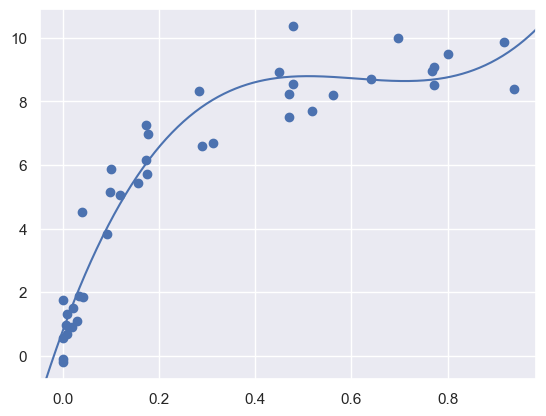

In [36]:
plt.scatter(X.ravel(), y)
lim = plt.axis()
# 上面确定好了最优的多项式项数是3相当于确定了最优的参数
# 接下来就指定模型的参数来拟合特征矩阵与目标向量然后预测测试集得到测试集的预测数据y_test
y_test = PolynomialRegression(3).fit(X, y).predict(X_test)
plt.plot(X_test.ravel(), y_test);
plt.axis(lim);

<p class='atcenter'>图 5-29：图 5-27 数据的交叉检验最优模型</p>

虽然寻找最优模型并不需要我们计算训练得分，但是检查训练得分
与验证得分之间的关系可以让我们对模型的性能有更加直观的认
识。


### 5.3.3 学习曲线

影响模型复杂度的另一个重要因素是最优模型往往受到训练数据量的影
响。例如，生成前面 5 倍的数据（200 个点）（如图 5-30 所示）：

In [ ]:
X2, y2 = make_data(200)
plt.scatter(X2.ravel(), y2);